In [57]:
#Import necessary libraries
!pip install scikit-learn

import numpy as np
import pandas as pd

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#Load the dataset
df = pd.read_csv('/content/energy_iter13.csv')

In [60]:
#Extract day from date
df['Date']=pd.to_datetime(df['Date'])
df['Day']=df['Date'].dt.day

In [61]:
df.head(5)

,Date,Demand(MW),Generation(MW),Temp(C),Year,Month,Season,IsHoliday,DemandGenGap(MW),Day
0,2024-12-31,0.294737,0.640671,0.073620,2024,12,0,0,0.751940,31
1,2024-12-30,0.315789,0.710960,0.263804,2024,12,0,0,0.788074,30
2,2024-12-29,0.315789,0.611273,0.226994,2024,12,0,0,0.705387,29
3,2024-12-28,0.215789,0.579603,0.226994,2024,12,0,0,0.784416,28
4,2024-12-27,0.294737,0.569848,0.239264,2024,12,0,1,0.693194,27


# **Random Forest**

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint

In [63]:
#Separate features and target for train-test split
#Drop the Date features beause we cant use date as datestamp format in Random Forest model
#Our Target is Energy Demand

X = df.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)'])
y = df['Demand(MW)']

#Split the dataset: 20% for Testing and 80% for Training
#For the consistency in result we use random_state= 42
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

#Define Forest classifier
rf_reg= RandomForestRegressor()

#Use different hyperparameter combinations
param_dist = {
    'n_estimators':randint(50,200,10),
    'max_depth':[None,10,20, 30],
    'min_samples_split':randint(2,10),
    'min_samples_leaf':randint(1,4)
    }

random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

#Find the best hyperparameters combinations
best_params = random_search.best_params_
print("Best Hyperparameters:",  best_params)

# Train the model with the best hyperparameters
rf_reg= RandomForestRegressor(**best_params)
rf_reg.fit(X_train, y_train)

#Prediction
y_pred = rf_reg.predict(X_test)

#Different types of evaluation parameter
r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)


print(f"R Squared: {r2:.5f}")
print(f'Mean absolute error: {mae:.5f}')
print(f'Mean Squared error: {mse:.5f}')
print(f'Root Mean Squared error: {rmse:.5f}')


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 163}
R Squared: 0.89845
Mean absolute error: 0.04623
Mean Squared error: 0.00421
Root Mean Squared error: 0.06487


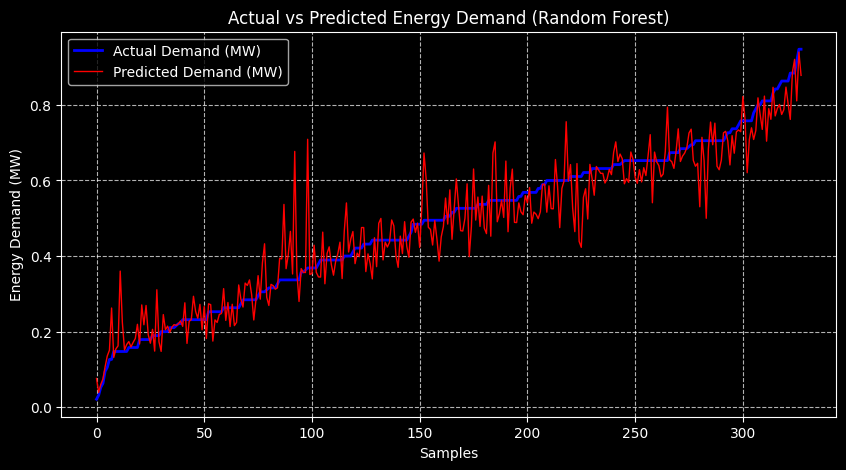

In [64]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
os.makedirs("./generated", exist_ok=True)

sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = np.array(y_pred)[sorted_indices]
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label="Actual Demand (MW)", linestyle='solid', color='blue', linewidth=2)
plt.plot(y_pred_sorted, label="Predicted Demand (MW)", linestyle='solid', color='red', linewidth=1)

sns.set_palette(palette='gnuplot2_r')

plt.xlabel("Samples")
plt.ylabel("Energy Demand (MW)")
plt.title("Actual vs Predicted Energy Demand (Random Forest)")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./generated/3.png',dpi=500)

plt.show()


# **Linear Regression**

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [66]:
#Scaling(Day,Year,Month)features just for Linear regression model
#Use Standard Scaler

features=["Day","Month","Year"]
scaler=StandardScaler()
df[features]=scaler.fit_transform(df[features])

print("scaling done")

scaling done


In [67]:
#Separate features and target for train-test split
#Drop the Date features beause we cant use date as datestamp format in Linear Regression
#Our Target is Energy Demand

X = df.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)'])
y = df['Demand(MW)']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

#Train the model
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

#prediction
y_pred=lr_model.predict(X_test)

#evaluation parameter
r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)

#Show result with different evaluation parameter
print(f"R Squared:{r2:.5f}")
print(f'Mean absolute error:{mae:.5f}')
print(f'Mean Squared error:{mse:.5f}')
print(f'Root Mean Squared error:{rmse:.5f}')

R Squared:0.85597
Mean absolute error:0.05866
Mean Squared error:0.00597
Root Mean Squared error:0.07726


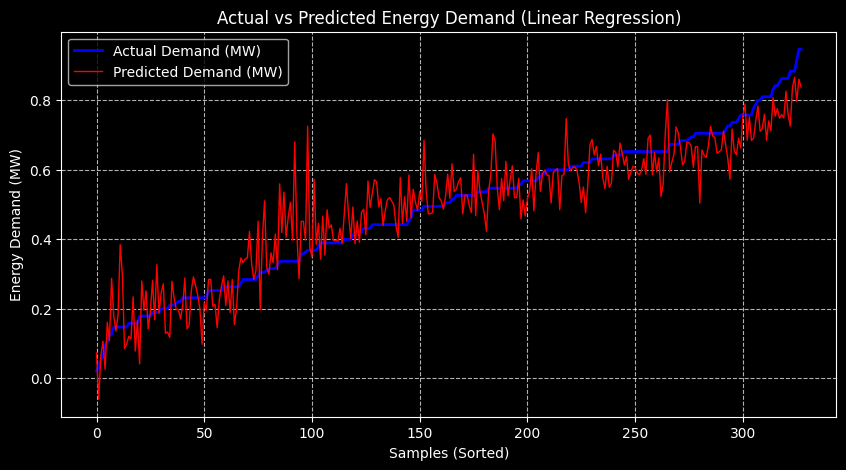

In [68]:
#visualization

import os
os.makedirs("./generated", exist_ok=True)
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = np.array(y_pred)[sorted_indices]

plt.style.use('dark_background')

plt.figure(figsize=(10, 5))
plt.plot(y_test_sorted, label="Actual Demand (MW)", linestyle='solid', color='blue', linewidth=2)
plt.plot(y_pred_sorted, label="Predicted Demand (MW)", linestyle='solid', color='red', linewidth=1)

plt.xlabel("Samples (Sorted)")
plt.ylabel("Energy Demand (MW)")
plt.title("Actual vs Predicted Energy Demand (Linear Regression)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./generated/4.png',dpi=500)
plt.show()
